
Specific heat: initial values
(Tc, nu, beta, beta/nu) = (1.2035, 0.83, 0.33, 0.4)


C:\Users\Victor\Documents\ResearchProjects\Potts Transition in Coupled XY Models\Plots\Send Peter\GitHubSync\Potts-XY\funcfssa3.py:167: RuntimeWarning: rho_c is out of range
  warnings.warn("rho_c is out of range", RuntimeWarning)


CV:
values: Tc, nu, zeta, omega1, a1, omega2, a2
[ 1.19469805  2.84127034  0.22582571  0.50316006  0.15858113  0.11640164
 -0.52590368]
errors
[0.0109242  0.61025784 0.13389296 0.15188734 0.02577225 0.01631047
 0.21698964]


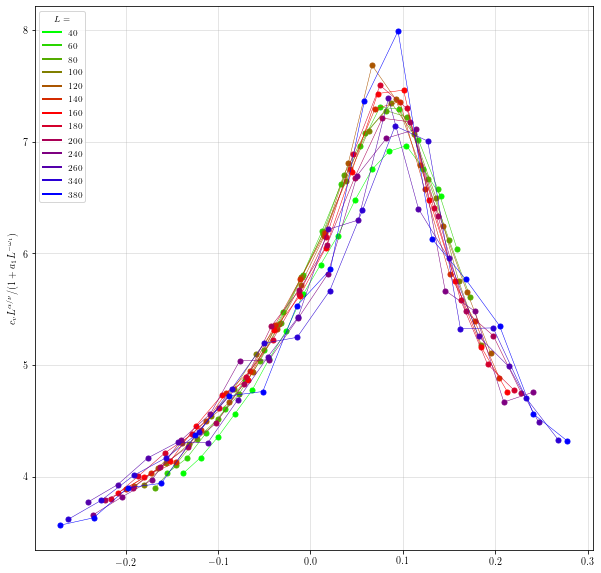

In [51]:
#!/usr/bin/env python
# coding: utf-8

#matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import math
import sys
import os
from random import shuffle
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fmin
from scipy.optimize import fsolve
from scipy import interpolate
from scipy.optimize import curve_fit
import scipy.optimize as opt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.signal import savgol_filter
from random import gauss
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif', 'size' : 10}) #, 'sans-serif':['Arial']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

color_red = (0.73, 0.13869999999999993, 0.)
color_orange = (1., 0.6699999999999999, 0.)
color_green = (0.14959999999999996, 0.43999999999999995, 0.12759999999999994)
color_blue = (0.06673600000000002, 0.164512, 0.776)
color_purple = (0.25091600000000003, 0.137378, 0.29800000000000004)
color_ocker = (0.6631400000000001, 0.71, 0.1491)
color_pink = (0.71, 0.1491, 0.44730000000000003)
color_brown = (0.651, 0.33331200000000005, 0.054683999999999955)

color_all = [color_red, color_orange, color_green, color_blue, color_purple, color_ocker,color_pink, color_brown]


from funcfssa import autoscale, scaledata   #usual scaling
from funcfssa2 import autoscale2, scaledata2  #correction in y
from funcfssa3 import autoscale3, scaledata3  #added correction in x

j2 = 1.0
j6 = 1.0
Kc = 0.0
lambda3 = 2.1
q_Q = 1
offset = 0
N_og = [40, 60, 80, 100, 120, 140, 160, 180, 200, 240, 260, 340, 380]
N_list = N_og

#N_fit_cv = 200
N_fit_cv = 300
####
#code
###

cv_ind = 1
chi_ind = 10 #for chi_sigma
m_ind = 9 #for m_sigma


data = np.load('Delta1_data_v2.npy',allow_pickle=True)


######
#-----------------------------------------------------------------------------------------------------------------------
#######
#parameters of the code
######
#-----------------------------------------------------------------------------------------------------------------------
######



#size_investigate = [20, 32]
Blocks = ['*','o', 'v', 'd','s','+', 'x']
#colors_size = ['blue', 'red', 'green', 'brown']

cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='brg_r')
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis_r')
colors_size = [scalarMap.to_rgba(i/(len(N_list)-1)) for i in range(len(N_list))]
#colors_size = [scalarMap.to_rgba(i/(len(N_og)-1)) for i in range(len(N_og))]


### scaling of specific heat
###

ls = N_list
a_arr = []
da_arr = []
flat_temp = []
ind = cv_ind  #here choose your fit
scaleC = 1

#take temp range of L=380 as the basic range of temperature for all of them
rhos = np.array(data[-1][0])

#for each system size L, download the data, and creat interpolation function.
#use rhos (the T list) for all of them to get the interpolated values for CV (a_arr)
#da_arr is a bogus list - could reduce 0.01 by a lot if needed.
for i in range(len(N_list)):
    i_og = i + offset
    prelim_y = (N_list[i]**(2*scaleC))*data[i_og][2*ind + 1]
    prelim_x = data[i_og][0] 
    
    spl_alt = InterpolatedUnivariateSpline(prelim_x, prelim_y, k=5)
    
    a_arr.append(spl_alt(rhos))
    da_arr.append(0.01*spl_alt(rhos))

a_arr = np.array(a_arr)
da_arr = np.array(da_arr)

# scaling function ansatz autoscale (no corrections to scaling) or autoscale2 (corrections to scaling on x or y) or autoscale3 (corrections to scaling on both x and y)
print('\nSpecific heat: initial values')
print('(Tc, nu, beta, beta/nu) = (1.2035, 0.83, 0.33, 0.4)')

#choose how you want to do the scaling
scale = 3
do_fit = True
#values obtained by previous fits
vals = [ 1.202, 1.8, 0.76, 0.31, 100, 0.0, 0.0] #good fit, alpha/nu ~ 0.4 like it should
#if you want the actual values for nu and alpha, but try to only fit the corrections, you probably get
#vals = [ 1.202, 0.83, 0.33, 0.85, 23.0, 0.0, 0.0]
#or this
#vals = [ 1.202, 0.9, 0.4, 0.7, 20.0, 0.0, 0.0]



if do_fit:

    if scale == 3:
        # [Tc, nu, \gamma, a1, \omega_1, a2, \omega_2]
        init_guess = [1.2, 5/6, 1/3, 0.1, 0.1, 0.1, 0.1]

        noisy_ret = autoscale3(ls, rhos, a_arr, da_arr, *init_guess)
        print('CV:')
        print('values: Tc, nu, zeta, omega1, a1, omega2, a2')
        print(noisy_ret['x'])
        print('errors')
        print(noisy_ret['errors'])

        noisy_auto_scaled_data =scaledata3(ls, rhos, a_arr, da_arr, *noisy_ret['x'])



    elif scale == 2:

        init_guess = [1.2, 5/6, 1/3, 0.1, 0.1]

        noisy_ret = autoscale2(ls, rhos, a_arr, da_arr, *init_guess)
        print('CV:')
        print('values: Tc, nu, zeta, omega, a')
        print(noisy_ret['x'])
        print('errors')
        print(noisy_ret['errors'])

        noisy_auto_scaled_data =scaledata2(ls, rhos, a_arr, da_arr, *noisy_ret['x'])


    elif scale == 1:

        init_guess = [1.2, 5/6, 1/3]

        noisy_ret = autoscale(ls, rhos, a_arr, da_arr, *init_guess)
        print('CV:')
        print('values: Tc, nu, zeta')
        print(noisy_ret['x'])
        print('errors')
        print(noisy_ret['errors'])

        noisy_auto_scaled_data =scaledata(ls, rhos, a_arr, da_arr, *noisy_ret['x'])

else:

    noisy_auto_scaled_data = scaledata3(ls, rhos, a_arr, da_arr, *vals)


#the values obtained by the fit
#[Tc, nu, alpha] = noisy_ret['x'][0:3]

#########
#--------
#########
#the figure environment

fig = plt.figure(figsize = (10,10) )
ax1 = plt.subplot()

#specific heat
for i in range(len(N_list)):
    #hand test
    #if you want to use your own values from vals, use next line
    #noisy_auto_scaled_data = scaledata3(ls, rhos, a_arr, da_arr, *vals)
    
    y_val = (noisy_auto_scaled_data.y.T)[:,i]
    x_val = (noisy_auto_scaled_data.x.T)[:,i]

    ax1.plot(x_val, y_val, marker ='o', markersize = 5, linestyle = '-', linewidth = 0.5,  color=colors_size[i])

#ax1.set_xlabel(r"$(T - T_{3})L^{1/\nu}/(1 + a_2 L^{-\omega_2})$", fontsize=10);
ax1.set_ylabel(r'$c_{v}L^{\alpha/\nu}/(1 + a_1 L^{-\omega_1})$ ', fontsize=10);

# ax1.set_xlabel(r"$\tilde{t} = (T - T_{potts})L^{1/\nu} (1 + a_2 L^{-\omega_2})^{-1}$", fontsize=10);
# ax1.set_ylabel(r'Scaled Specific Heat $\tilde{c}_{v} = L^{\beta/\nu} c_{v} (1 + a_1 L^{-\omega_1})^{-1}$ ', fontsize=10);


#do the legend and append at the end
# patches_lg = []
# for i in range(len(N_list)):
#     patches_lg.append(patches.Patch(color=colors_size[i], label='L='+str(int(N_list[i]))))
#ax.legend(handles=patches_lg, loc='upper right', bbox_to_anchor=(0.98,0.95), ncol=1,fontsize = 10)

patches_lg = []
for i in range(len(N_list)):
    patches_lg.append(Line2D([0], [0], color=colors_size[i], linewidth = 2, linestyle = '-', label='$'+str(int(N_list[i]))+'$') )
ax1.legend(handles=patches_lg, loc='upper left', title = '$L = $', title_fontsize = 9, ncol=1, fontsize = 9)

ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.grid(which='major', axis='both', linestyle='-', alpha = 0.4)
ax1.grid(which='minor', axis='both', linestyle='-', alpha = 0.2)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)



#plt.savefig('./scaleCV.png', format='png', dpi = 100, bbox_inches='tight')
plt.show()


In [46]:
#a function that returns the cv scaling plot only
#easy to play with vals and see the result
def figure_noscale():

    fig = plt.figure(figsize = (10,10) )
    ax1 = plt.subplot()

    #specific heat
    for i in range(len(N_list)):
        #hand test
        
        y_val = a_arr[i]
        x_val = rhos

        ax1.plot(x_val, y_val, marker ='o', markersize = 5, linestyle = '-', linewidth = 0.5,  color=colors_size[i])

    ax1.set_xlabel(r"$(T - T_{3})L^{1/\nu}/(1 + a_2 L^{-\omega_2})$", fontsize=10);
    ax1.set_ylabel(r'$c_{v}L^{\alpha/\nu}/(1 + a_1 L^{-\omega_1})$ ', fontsize=10);

    # ax1.set_xlabel(r"$\tilde{t} = (T - T_{potts})L^{1/\nu} (1 + a_2 L^{-\omega_2})^{-1}$", fontsize=10);
    # ax1.set_ylabel(r'Scaled Specific Heat $\tilde{c}_{v} = L^{\beta/\nu} c_{v} (1 + a_1 L^{-\omega_1})^{-1}$ ', fontsize=10);


    #do the legend and append at the end
    # patches_lg = []
    # for i in range(len(N_list)):
    #     patches_lg.append(patches.Patch(color=colors_size[i], label='L='+str(int(N_list[i]))))
    #ax.legend(handles=patches_lg, loc='upper right', bbox_to_anchor=(0.98,0.95), ncol=1,fontsize = 10)

    patches_lg = []
    for i in range(len(N_list)):
        patches_lg.append(Line2D([0], [0], color=colors_size[i], linewidth = 2, linestyle = '-', label='$'+str(int(N_list[i]))+'$') )
    ax1.legend(handles=patches_lg, loc='upper left', title = '$L = $', title_fontsize = 9, ncol=1, fontsize = 9)

    ax1.xaxis.set_minor_locator(MultipleLocator(5))
    ax1.grid(which='major', axis='both', linestyle='-', alpha = 0.4)
    ax1.grid(which='minor', axis='both', linestyle='-', alpha = 0.2)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)



    #plt.savefig('./scaleCV.png', format='png', dpi = 100, bbox_inches='tight')
    plt.show()

    return

def figure_fit(vals):

    fig = plt.figure(figsize = (10,10) )
    ax1 = plt.subplot()

    #specific heat
    for i in range(len(N_list)):
        #hand test

        noisy_auto_scaled_data =scaledata3(ls, rhos, a_arr, da_arr, *vals)
        y_val = (noisy_auto_scaled_data.y.T)[:,i]
        x_val = (noisy_auto_scaled_data.x.T)[:,i]


        ax1.plot(x_val, y_val, marker ='o', markersize = 5, linestyle = '-', linewidth = 0.5,  color=colors_size[i])

    ax1.set_xlabel(r"$(T - T_{3})L^{1/\nu}/(1 + a_2 L^{-\omega_2})$", fontsize=10);
    ax1.set_ylabel(r'$c_{v}L^{\alpha/\nu}/(1 + a_1 L^{-\omega_1})$ ', fontsize=10);

    # ax1.set_xlabel(r"$\tilde{t} = (T - T_{potts})L^{1/\nu} (1 + a_2 L^{-\omega_2})^{-1}$", fontsize=10);
    # ax1.set_ylabel(r'Scaled Specific Heat $\tilde{c}_{v} = L^{\beta/\nu} c_{v} (1 + a_1 L^{-\omega_1})^{-1}$ ', fontsize=10);


    #do the legend and append at the end
    # patches_lg = []
    # for i in range(len(N_list)):
    #     patches_lg.append(patches.Patch(color=colors_size[i], label='L='+str(int(N_list[i]))))
    #ax.legend(handles=patches_lg, loc='upper right', bbox_to_anchor=(0.98,0.95), ncol=1,fontsize = 10)

    patches_lg = []
    for i in range(len(N_list)):
        patches_lg.append(Line2D([0], [0], color=colors_size[i], linewidth = 2, linestyle = '-', label='$'+str(int(N_list[i]))+'$') )
    ax1.legend(handles=patches_lg, loc='upper left', title = '$L = $', title_fontsize = 9, ncol=1, fontsize = 9)

    ax1.xaxis.set_minor_locator(MultipleLocator(5))
    ax1.grid(which='major', axis='both', linestyle='-', alpha = 0.4)
    ax1.grid(which='minor', axis='both', linestyle='-', alpha = 0.2)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)



    #plt.savefig('./scaleCV.png', format='png', dpi = 100, bbox_inches='tight')
    plt.show()

    return

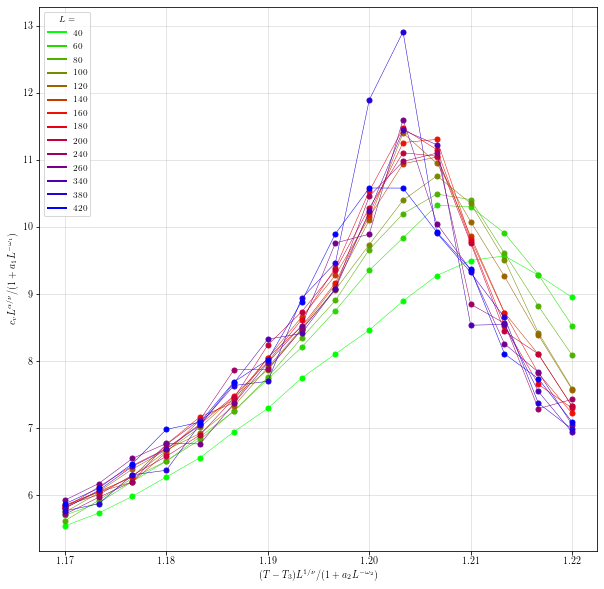

In [47]:
#no scaling
figure_noscale()

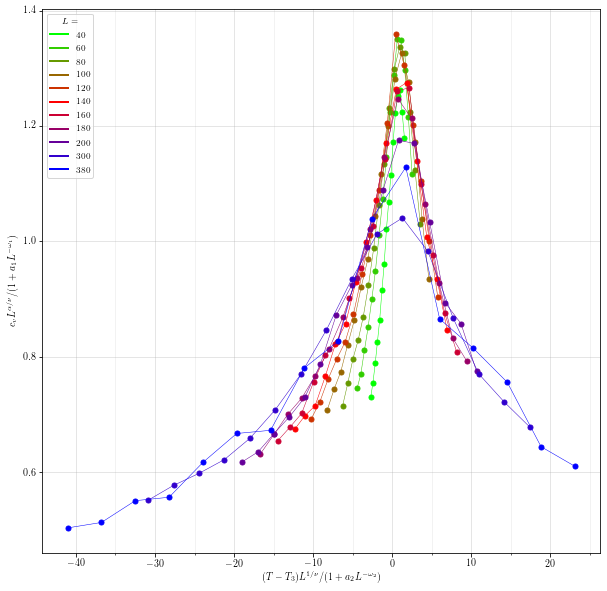

In [37]:
#Tc, nu, alpha, omega1, a1, omega2, a2
#testV = [ 1.202, 1.8, 0.76, 0.31, 100, 0.0, 0.0]
testV = [ 1.202, 0.83, 0.33, 1.0, 30.0, 0.0, 0.0]
#print("alpha/nu = ", testV[2]/testV[1])
figure_fit(testV)